# Compute the effects of solution on flows

This notebook illustrates the interface for computing the changes by solutions. For more detailed description of the why-s and how-s and the Solutions, see the notebooks with lower fm-number.

## The algorithm expects a graph (G) with these properties

+ vertices have unique IDs, stored in an internal vertex property called *id* (string)

+ there is only a single edge between two vertices (no parallels)

+ edges have an internal edge property called *flow*, which is a dictionary that must have:

    + *amount* : float
    
    + *composition* : dictionary of { material (string) : amount (float) }
    

## The algorithm expects the following input

Currently there are 6 parameters for computing changes on a graph. From these 6, 3 are required and 3 are optional. This second group is only needed when a flows needs to be shifted. For more details see `solution_object.json`

### Input

+ a graph (G) as described above, type `graph_tool.Graph`

+ a *solution object* as described by the `solution_object.json` schema

### Output

+ an Edge PropertyMap of the signed changes that is caused by the solution

In [1]:
import graph_tool as gt
from graph_tool import util
import graph_tool.search
from graph_tool import Edge, Graph, Vertex, PropertyMap
import graph_tool.draw

import cairo
import numpy as np
import datetime

import  os
os.chdir("/tmp") # the ./flow_modelling dir is mapped to /tmp in the Docker container

In [2]:
print("Last run:", datetime.datetime.now().date().isoformat())

Last run: 2019-01-23


In [35]:
def find_vertex_index(G, vprop_id):
    """Finds the index of a vertex with the given ID property
    
    The order of the vertices traversed by the vertices() iterator 
    always corresponds to the vertex index ordering, as given by the vertex_index property map.
    
    vprop_id : int
        The vertex ID property
    
    Returns
    -------
    vertex index : int
    """
    assert isinstance(vprop_id, int)
    for i, v in enumerate(G.vertices()):
        if G.vp.id[v] == vprop_id:
            return i

def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding amount.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_amount
        Edge property (amount), double
    eprop_amount_text
        Edge property (amount), string. Only needed for plotting the amounts on the edges with graph-tool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    amount_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            amount_list.append(float(prop['amount']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_amount = g.new_edge_property("float", vals=amount_list)
    eprop_amount_text = g.new_edge_property("string", vals=[round(i,2) for i in amount_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    return (g, eprop_material, eprop_amount, eprop_amount_text)


def define_mask(G, edges):
    """Create an edge mask for the edges that define the solution
    
    Parameters
    ----------
    G : Graph, directed
    edges : an iterable of edge objects that will be included, the rest of the edges are filtered out from the graph
    
    Returns
    --------
    tuple
        mask : Edge ProperyMap (bool) of the masked edges
        cols : Edge ProperyMap (string) of the edge colours. Used for plotting the included edges (green), excluded (red) with graph-tools
    """
    cols = []
    mask = G.new_edge_property("bool")
    for i,e in enumerate(G.edges()):
        if e in edges:
            mask[e] = True
            cols.append("green")
        else:
            mask[e] = False
            cols.append("red")
    
    return (mask, G.new_edge_property("string", vals=cols))


class NodeVisitor(gt.search.BFSVisitor):

    def __init__(self, name, solution, amount, visited, change):
        self.id = name
        self.solution = solution
        self.amount = amount
        self.visited = visited
        self.change = change

    def discover_vertex(self, u):
        """This is invoked when a vertex is encountered for the first time."""
        pass

    def examine_vertex(self, u):
        """Compute the amount change on each inflow for the vertex
        
        This function is invoked on a vertex as it is popped from the queue.

        Returns
        -------
        dict
            {edge : change}
        """
        changes = {}
        if u.in_degree() > 0:
            all_in = list(u.in_edges())
            for i,e in enumerate(all_in):
                if not self.visited[e]:
                    e_src = e.source()
                    e_src_out = [e for e in e_src.out_edges()]
                    if len(e_src_out) > 1:
                        # For the case when an inflow edge shares the source vertex
                        self.change[e] = ( self.amount[e] / sum([self.amount[out_f] for out_f in e_src_out]) ) * self.solution
                    else:
                        self.change[e] = ( self.amount[e] / sum([self.amount[in_f] for in_f in all_in]) ) * self.solution
                    #print(self.id[e.source()], '-->', self.id[e.target()], self.change[e])
                    self.visited[e] = True
        else:
            #print("source node,", u.vp.id)
            pass
        
def traverse_graph(G, edge, include, solution, amount, upstream=True):
    """Traverse the graph in a breadth-first-search manner
    
    Parameters
    ----------
    G : the graph to explore
    edge : the starting edge, normally this is the *solution edge*
    visited : edge propery map (bool) to indicate which edge have been visited
    include : edge propery map (bool) to indicate the edges that are part of the solution definition
    upstream : The direction of traversal. When upstream is True, the graph is explored upstream first, otherwise downstream first.  
    
    Returns
    -------
    Edge ProperyMap (float)
        The signed change on the edges
    """
    # Property map for keeping track of the visited edge. Once an edge has been visited
    # it won't be processed anymore.
    r = (False for x in G.get_edges())
    visited = G.new_edge_property("bool", vals=r)
    change = G.new_edge_property("float")
    #G.edge_properties["change"] = change
    # By default we go upstream first, because 'demand dictates supply'
    if upstream:
        G.set_reversed(True)
    else:
        G.set_reversed(False)
    node = edge.target()
    # We are only interested in the edges that define the solution
    G.set_edge_filter(include)
    #print("\nTraversing in 1. direction")
    gt.search.bfs_search(G, node, NodeVisitor(G.vp["id"], solution, amount, visited, change))
    if G.is_reversed():
        G.set_reversed(False)
    else:
        G.set_reversed(True)
    #print("\nTraversing in 2. direction")
    gt.search.bfs_search(G, node, NodeVisitor(G.vp["id"], solution, amount, visited, change))
    del visited
    G.set_reversed(False)
    G.clear_filters()
    return change


def shift_flow(G, edge_to_remove, target_vertex, eprop_material, eprop_mass, eprop_mass_text):
    """Shifts a flow by removing an existing flow and adding a new flow
    
    Return
    ------
    graph
        (Copy of the graph with the shifted flow, copies of the property maps with the shifted flow)
    """
    assert isinstance(G, Graph)
    assert isinstance(edge_to_remove, Edge)
    assert isinstance(target_vertex, Vertex)
    assert isinstance(eprop_material, PropertyMap)
    assert isinstance(eprop_mass, PropertyMap)
    assert isinstance(eprop_mass_text, PropertyMap)
    
    g = G.copy()
    mat = g.new_edge_property("string", vals=eprop_material)
    mass = g.new_edge_property("float", vals=eprop_mass)
    mass_text = g.new_edge_property("string", vals=eprop_mass_text)
    
    edge_to_add = g.add_edge(edge_to_remove.source(), target_vertex)
    mat[edge_to_add] = eprop_material[edge_to_remove]
    mass[edge_to_add] = eprop_mass[edge_to_remove]
    mass_text[edge_to_add] = eprop_mass_text[edge_to_remove]
    g.remove_edge(edge_to_remove)
    
    return (g, edge_to_add, mat, mass, mass_text)


def compare_graphs(G1, G2):
    """Compare G2 to G1 and report the changes in vertices and edges"""
    assert "id" in G1.vertex_properties.keys()
    assert "id" in G2.vertex_properties.keys()
    vtx_removed = set(G1.vp["id"]) - set(G2.vp["id"])
    vtx_added = set(G2.vp["id"]) - set(G1.vp["id"])
    e_removed = [e for e in G1.edges() if e not in G2.edges()]
    e_added = [e for e in G2.edges() if e not in G1.edges()]
    
    print("Nodes removed from G1:", ", ".join(vtx_removed))
    print("Nodes added to G1:", ", ".join(vtx_added))
    print("\nFlows removed from G1:")
    for e in e_removed:
        print(G1.vp.id[e.source()], '-->', G1.vp.id[e.target()])
    print("\nFlows added to G1:")
    for e in e_added:
        print(G2.vp.id[e.source()], '-->', G2.vp.id[e.target()])
    pass


def apply_ratio(G, solution_edge, ratios, mass):
    """Apply the ratio to the flows
    
    Returns
    -------
    Edge PropertyMap
        Signed change of the amount
    """
    change_map = G.new_edge_property("float")
    v = solution_edge.target()
    for e in v.in_edges():
        if e != solution_edge:
            change = ( mass[solution_edge] * ratios[solution_edge] ) - mass[solution_edge]
            change_map[e] = change
            #print(G.vp.id[e.source()], '-->', G.vp.id[e.target()], change)
        else:
            change_map[e] = 0.0
    return change_map


def plot_sol_amount(g, amount, colors=None):
    amount_text = g.new_edge_property("string", vals=[round(i,2) for i in amount])
    if colors:
        eprops_p = {"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors}
    else:
        eprops_p = {"font_slant":cairo.FONT_SLANT_ITALIC}
    pos = gt.draw.sfdp_layout(g)
    gt.draw.graph_draw(g, vertex_size=15, vertex_text=g.vp.id,
                       pos=pos,
                       vprops={"text_position":0.5, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops=eprops_p,
                       edge_text=amount_text,
                       output_size=(700,600), inline=True)

    
def plot_sol_materials(g, eprop_material, colors=None):
    if colors:
        eprops_p = {"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors}
    else:
        eprops_p = {"font_slant":cairo.FONT_SLANT_ITALIC}
    gt.draw.graph_draw(g, vertex_size=15, vertex_text=g.vp.id,
                       vprops={"text_position":0.5, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops=eprops_p,
                       edge_text=eprop_material,
                       output_size=(700,600), inline=True)

In [4]:
G = gt.load_graph("cucumba_actors.gt")

In [5]:
g_split, eprop_material, eprop_amount, eprop_amount_text = split_flows(G)

In [6]:
for v in g_split.vertices():
    print(g_split.vp.id[v], g_split.vp.name[v])

1 oil_rig_den_haag
2 oil_rig_rotterdam
3 oil_refinery_rotterdam
5 production_utrecht
6 production_leiden
7 recycling_wageningen
9 ah_den_haag_1
10 ah_den_haag_2
11 ah_den_haag_3
12 packaging_leiden
13 packaging_utrecht
14 cucumber_farm_naaldwijk_1
15 cucumber_farm_naaldwijk_2
16 milk_farm_friesland_1
17 milk_farm_friesland_2
18 incinerator_eindhoven
19 paper_waste_collector_enschede
20 organic_waste_collector_nijmegen


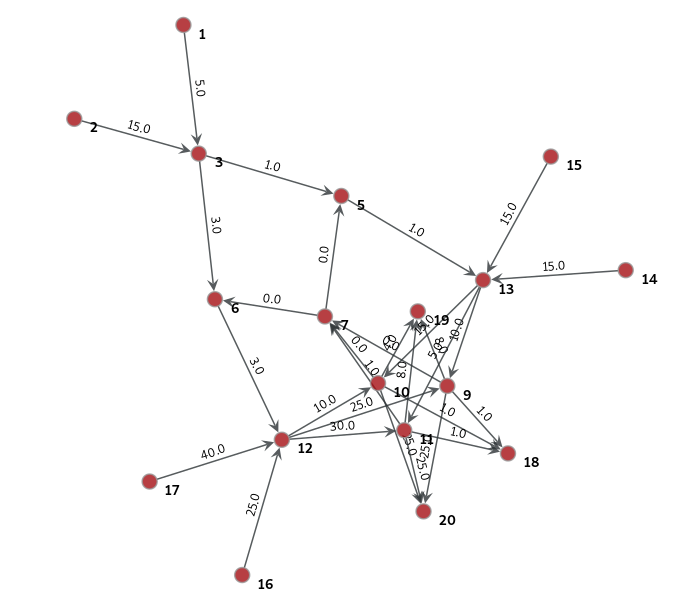

In [7]:
plot_sol_amount(g_split, eprop_amount)

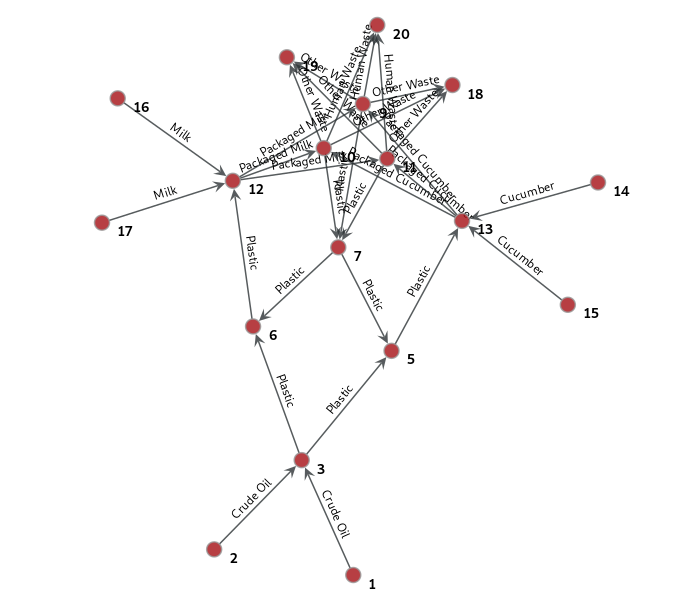

In [8]:
plot_sol_materials(g_split, eprop_material)

## Define the `solution_flows`

In [36]:
for i, e in enumerate(g_split.edges()):
    print(i, g_split.vp.name[e.source()], '(id:', g_split.vp.id[e.source()], ')', '-->', \
          g_split.vp.name[e.target()], '(id:', g_split.vp.id[e.target()], ')')

0 oil_rig_den_haag (id: 1 ) --> oil_refinery_rotterdam (id: 3 )
1 oil_rig_rotterdam (id: 2 ) --> oil_refinery_rotterdam (id: 3 )
2 oil_refinery_rotterdam (id: 3 ) --> production_utrecht (id: 5 )
3 oil_refinery_rotterdam (id: 3 ) --> production_leiden (id: 6 )
4 production_utrecht (id: 5 ) --> packaging_utrecht (id: 13 )
5 production_leiden (id: 6 ) --> packaging_leiden (id: 12 )
6 recycling_wageningen (id: 7 ) --> production_utrecht (id: 5 )
7 recycling_wageningen (id: 7 ) --> production_leiden (id: 6 )
8 ah_den_haag_1 (id: 9 ) --> incinerator_eindhoven (id: 18 )
9 ah_den_haag_1 (id: 9 ) --> paper_waste_collector_enschede (id: 19 )
10 ah_den_haag_1 (id: 9 ) --> organic_waste_collector_nijmegen (id: 20 )
11 ah_den_haag_1 (id: 9 ) --> recycling_wageningen (id: 7 )
12 ah_den_haag_2 (id: 10 ) --> incinerator_eindhoven (id: 18 )
13 ah_den_haag_2 (id: 10 ) --> paper_waste_collector_enschede (id: 19 )
14 ah_den_haag_2 (id: 10 ) --> organic_waste_collector_nijmegen (id: 20 )
15 ah_den_haag_2 (

In [37]:
pl = find_vertex_index(g_split, 12)
mf1 = find_vertex_index(g_split, 16)
mf2 = find_vertex_index(g_split, 17)

In [50]:
# define the solution_flows
pe = []
for v in [mf1, mf2]:
    pe = pe + g_split.edge(g_split.vertex(v), g_split.vertex(pl), all_edges=True)

In [51]:
solution_flows = [e for e in pe if eprop_material[e] == 'Milk'] # the specific edge (blue)
solution = -26.0

In [55]:
print("Current total milk amount after Farming:", round(sum(eprop_amount[f] for f in solution_flows), 2))
print("Solution:", solution)
print("Total milk amount after implementing the solution:", round(sum(eprop_amount[f] for f in solution_flows) + solution,2))

Current total milk amount after Farming: 65.0
Solution: -26.0
Total milk amount after implementing the solution: 39.0


The procedure below simulates the user who selects the edges for a Solution

In [7]:
solution_edges = []
material = 'milk'

# edge
v_source = util.find_vertex(g_split, g_split.vp["id"], "Farm")
v_target = util.find_vertex(g_split, g_split.vp["id"], "Packaging")
e = g_split.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if eprop_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (g_split.vp.id[v_source[0]], g_split.vp.id[v_target[0]])
solution_edges.extend(e_to_add)

# edge
v_source = util.find_vertex(g_split, g_split.vp["id"], "Packaging")
v_target = util.find_vertex(g_split, g_split.vp["id"], "Consumption")
e = g_split.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if eprop_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (g_split.vp.id[v_source[0]], g_split.vp.id[v_target[0]])
solution_edges.extend(e_to_add)

# edge
material = 'human waste'
v_source = util.find_vertex(g_split, g_split.vp["id"], "Consumption")
v_target = util.find_vertex(g_split, g_split.vp["id"], "Waste")
e = g_split.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if eprop_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (g_split.vp.id[v_source[0]], g_split.vp.id[v_target[0]])
solution_edges.extend(e_to_add)

# edge
material = 'other waste'
v_source = util.find_vertex(g_split, g_split.vp["id"], "Consumption")
v_target = util.find_vertex(g_split, g_split.vp["id"], "Waste 2")
e = g_split.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if eprop_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (g_split.vp.id[v_source[0]], g_split.vp.id[v_target[0]])
solution_edges.extend(e_to_add)

edge_mask, ecolors = define_mask(g_split, solution_edges)
ecolors[solution_edge] = "blue"

### Compute the changes

In [8]:
changes = traverse_graph(g_split, solution_edge, edge_mask, solution, eprop_amount, upstream=True)

In [9]:
for i,e in enumerate(g_split.edges()):
    if changes[e] != 0.0:
        print(g_split.vp.id[e.source()], '-->', g_split.vp.id[e.target()], changes[e])

Farm --> Packaging -26.0
Packaging --> Consumption -26.0
Consumption --> Waste -20.526315789473685
Consumption --> Waste 2 -5.473684210526315


### Apply the changes
Once the changes are computed, the new *amount* can be computed for each edge as *amount + change*

## 2. Computing add/remove flows

### Case of Bread to Beer

In [10]:
G = gt.load_graph("breadbeer.gt")

g_split, eprop_material, eprop_amount, eprop_amount_text = split_flows(G)

In [11]:
v_source = util.find_vertex(g_split, g_split.vp["id"], "Households")
v_target = util.find_vertex(g_split, g_split.vp["id"], "Incineration")
pe = g_split.edge(v_source[0], v_target[0], all_edges=True)
edge_to_remove = [e for e in pe if eprop_material[e] == 'bread'][0] # because there are prallel edges, we need to identify them by material

v_target = util.find_vertex(g_split, g_split.vp["id"], "Brewery")[0]

In [12]:
# Shift the flow Households-->Brewery
shifted_g, solution_edge, shifted_material, shifted_mass, shifted_mass_text = shift_flow(g_split, \
                                                                          edge_to_remove=edge_to_remove, \
                                                                          target_vertex=v_target, \
                                                                          eprop_material=eprop_material, \
                                                                          eprop_mass=eprop_amount, \
                                                                          eprop_mass_text=eprop_amount_text)

In [13]:
compare_graphs(g_split, shifted_g)

Nodes removed from G1: 
Nodes added to G1: 

Flows removed from G1:
Households --> Incineration

Flows added to G1:
Households --> Brewery


In [14]:
solution_edges = []

# edge
material = 'barley'
v_source = util.find_vertex(shifted_g, shifted_g.vp["id"], "Farm")
v_target = util.find_vertex(shifted_g, shifted_g.vp["id"], "Brewery")
e = shifted_g.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if shifted_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (shifted_g.vp.id[v_source[0]], shifted_g.vp.id[v_target[0]])
solution_edges.extend(e_to_add)

# edge
material = 'bread'
v_source = util.find_vertex(shifted_g, shifted_g.vp["id"], "Households")
v_target = util.find_vertex(shifted_g, shifted_g.vp["id"], "Brewery")
e = shifted_g.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if shifted_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (shifted_g.vp.id[v_source[0]], shifted_g.vp.id[v_target[0]])
solution_edges.extend(e_to_add)

edge_mask, ecolors = define_mask(shifted_g, solution_edges)
ecolors[solution_edge] = "blue"

In [15]:
ratios = shifted_g.new_edge_property("float")
ratios[solution_edge] = (3/5) * (1/2)

In [22]:
changes = apply_ratio(shifted_g, solution_edge, ratios, shifted_mass)

In [23]:
for i,e in enumerate(g_split.edges()):
    if changes[e] != 0.0:
        print(g_split.vp.id[e.source()], '-->', g_split.vp.id[e.target()], changes[e])

Farm --> Brewery -3.5
